# 训练

In [2]:
# ./src/scripts/mmdet_train.sh yolov3

# 变量定义

In [1]:
import glob

# 参数
model_name = 'yolov3'
model_stru = ''
model_cfg = '_train_val'  # _train_val _train_val_aug
exp_name = f'{model_name}{model_stru}{model_cfg}'
USE_VAL = 'val' in model_cfg
exp_id = '20231020_012418'

# 路径
cfg_path = f'cfg/{model_name}_lard.py'
best_model_path = f'runs/mmdetection/{exp_name}/train/'
files = glob.glob(f'{best_model_path}/best_coco_bbox_mAP_epoch_*.pth')  # TODO: 按epoch数排序
best_model_path = files[0] if files else None
train_log_path = f'runs/mmdetection/{exp_name}/train/{exp_id}/vis_data/scalars.json'

print(f'{exp_name=}')
print(f'{best_model_path=}')
print(f'{train_log_path=}')


exp_name='yolov3_train_val'
best_model_path='runs/mmdetection/yolov3_train_val/train/best_coco_bbox_mAP_epoch_20.pth'
train_log_path='runs/mmdetection/yolov3_train_val/train/20231020_012418/vis_data/scalars.json'


# 优化
本代码只执行一次

In [4]:
import os

# 优化anchor
path_anchor = f'runs/mmdetection/{exp_name}/'
os.makedirs(path_anchor, exist_ok=True)

# 原始anchor 3rdparty/mmdetection/configs/yolo/yolov3_d53_8xb8-ms-608-273e_coco.py
# [(116, 90), (156, 198), (373, 326)],
# [(30, 61), (62, 45), (59, 119)],
# [(10, 13), (16, 30), (33, 23)]

! python 3rdparty/mmdetection/tools/analysis_tools/optimize_anchors.py \
    cfg/yolov3_lard.py \
    --device cuda: 0 \
    --input-shape 640 640 \
    --algorithm k-means \
    --output-dir runs/mmdetection/yolov3_train_val/


usage: optimize_anchors.py [-h] [--device DEVICE]
                           [--input-shape INPUT_SHAPE [INPUT_SHAPE ...]]
                           [--algorithm ALGORITHM] [--iters ITERS]
                           [--output-dir OUTPUT_DIR]
                           config
optimize_anchors.py: error: unrecognized arguments: - -device cuda: 0 - -input-shape 640 640 - -algorithm k-means - -output-dir runs/mmdetection/yolov3_train_val/


In [ ]:
import json

output = []
with open(path_anchor+"/anchor_optimize_result.json", 'r') as f:
    anchors = json.load(f)
    for anchor in anchors:
        output.append(tuple(anchor))
print(f"原始输出: {anchors}")

print("可复制格式: ")
print(f"{output[0+6:3+6]},")
print(f"{output[0+3:3+3]},")
print(output[0:3])

# 优化后
# [(120, 76), (198, 113), (366, 188)],
# [(42, 22), (46, 41), (75, 52)],
# [(10, 14), (19, 19), (26, 31)]


原始输出: [[10, 14], [19, 19], [26, 31], [42, 22], [46, 41], [75, 52], [120, 76], [198, 113], [366, 188]]
可复制格式: 
[(120, 76), (198, 113), (366, 188)],
[(42, 22), (46, 41), (75, 52)],
[(10, 14), (19, 19), (26, 31)]


# 日志分析

['lr', 'data_time', 'grad_norm', 'loss', 'loss_cls', 'loss_conf', 'loss_xy', 'loss_wh', 'time', 'iter', 'memory', 'step']
['coco/bbox_mAP', 'coco/bbox_mAP_50', 'coco/bbox_mAP_75', 'coco/bbox_mAP_s', 'coco/bbox_mAP_m', 'coco/bbox_mAP_l', 'data_time', 'time']
最大map: (20)0.658


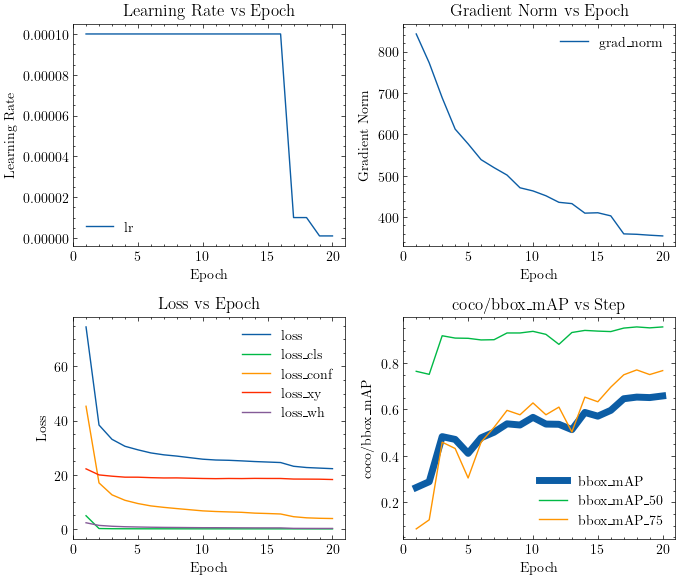

In [3]:
from src.utils.read import read_mmdet_train_log_json
from src.utils.plot import plot_mmdet_yolov3_train_log

df_train, df_val = read_mmdet_train_log_json(train_log_path)
plot_mmdet_yolov3_train_log(df_train, df_val, exp_name=exp_name)

# 测试

In [5]:
! src/scripts/mmdet_test.sh {cfg_path} {best_model_path} {exp_name}

11/09 18:00:09 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.7 (default, Sep 16 2021, 13:09:58) [GCC 7.5.0]
    CUDA available: True
    numpy_random_seed: 635309724
    GPU 0: NVIDIA GeForce GTX 1070
    CUDA_HOME: /usr/local/cuda-11.1
    NVCC: Cuda compilation tools, release 11.1, V11.1.74
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 1.10.2+cu111
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,

# 评估

In [5]:
# 提供两种测试评价方案，结果一致
# 方式1: pycocotools
import pandas as pd
from src.utils.metric import coco_metrics_name
from src.utils.metric import cal_coco_metrics

# 保存评价结果对象
coco_evals = {}
# 构造dataframe
all_metrics = {}

# 在各测试集进行推理
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:

    print(f'正在评价: {data_type}')
    annotation_file = f'datasets/lard/annotations/instances_{data_type}.json'
    prediction_file = f'runs/mmdetection/{exp_name}/test/coco_detection/prediction_{data_type}.bbox.json'
    cocoEval = cal_coco_metrics(annotation_file, prediction_file)
    coco_evals[data_type] = cocoEval
    all_metrics[data_type] = cocoEval.stats

all_metrics = pd.DataFrame(all_metrics, index=coco_metrics_name)
display(all_metrics.round(3))


# 方式2: eval_metric.py
# ! python 3rdparty/mmdetection/tools/analysis_tools/eval_metric.py \
#     {cfg_path} \
#     runs/mmdetection/{exp_name}/test/coco_detection/prediction_test_synth.pkl \
#     --cfg-options \
#     test_evaluator.format_only=False

正在评价: test_synth
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.51s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.655
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.946
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.703
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.717
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.718
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

,test_synth,test_real_nominal,test_real_edge
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.655,0.456,0.189
"AP (IoU=0.50, area=all, maxDets=100)",0.946,0.757,0.366
"AP (IoU=0.75, area=all, maxDets=100)",0.767,0.492,0.181
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.134,0.119
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.557,0.329,0.121
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.703,0.655,0.254
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.717,0.514,0.234
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.718,0.528,0.252
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.718,0.528,0.252
"AR (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.196,0.140


test_synth
precision.shape=(10, 101, 1, 4, 3), recall.shape=(10, 1, 4, 3)


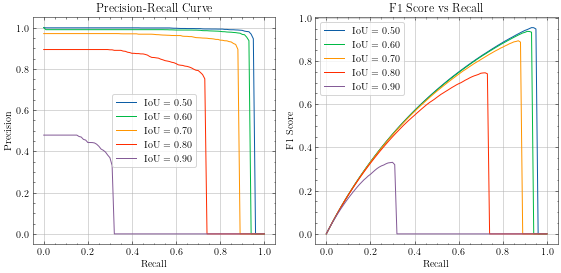

test_real_nominal
precision.shape=(10, 101, 1, 4, 3), recall.shape=(10, 1, 4, 3)


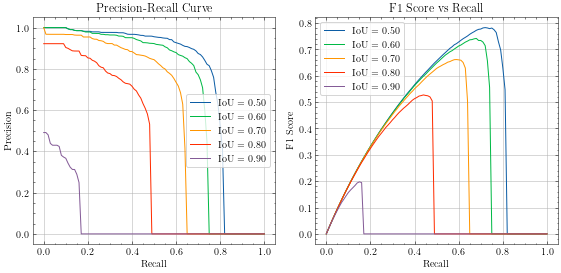

test_real_edge
precision.shape=(10, 101, 1, 4, 3), recall.shape=(10, 1, 4, 3)


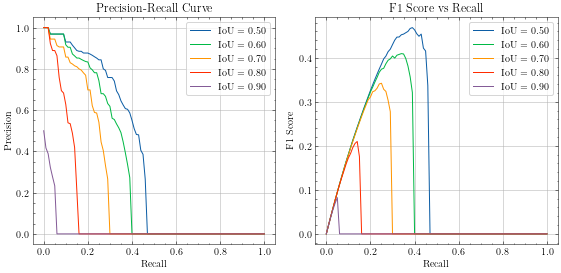

In [6]:
from src.utils.plot import plot_pr_curve

plot_pr_curve(coco_evals, iou_indices=[0, 2, 4, 6, 8], exp_name=exp_name)

# 测速

In [2]:
! src/scripts/mmdet_speed.sh {cfg_path} {best_model_path}

11/07 20:58:02 - mmengine - INFO - before build: 
11/07 20:58:02 - mmengine - INFO - (GB) mem_used: 1.62 | uss: 1.15 | pss: 1.16 | total_proc: 1
Loads checkpoint by local backend from path: runs/mmdetection/yolov3_train_val/train/best_coco_bbox_mAP_epoch_20.pth
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
11/07 20:58:08 - mmengine - INFO - after build: 
11/07 20:58:08 - mmengine - INFO - (GB) mem_used: 3.60 | uss: 3.68 | pss: 3.69 | total_proc: 1
11/07 20:59:05 - mmengine - INFO - ==================================
11/07 20:59:05 - mmengine - INFO - Done image [500/2000], fps: 20.7 img/s, times per image: 48.4 ms/img, cuda memory: 358 MB
11/07 20:59:05 - mmengine - INFO - (GB) mem_used: 3.64 | uss: 3.75 | pss: 3.75 | total_proc: 1
11/07 20:59:58 - mmengine - INFO - ==================================
11/07 20:59:58 - mmengine - INFO - Done image [1000/2000], fps: 20.7 img/s, times per image: 48.3 ms/img, cuda memory: 357 MB
11/07 20:59:58 - mmengine

In [ ]:
# 11/03 18:16:31 - mmengine - INFO - ============== Done ==================
# 11/03 18:16:31 - mmengine - INFO - Overall fps: 21.1 img/s, times per image: 47.4 ms/img

# 11/03 18:18:50 - mmengine - INFO - ============== Done ==================
# 11/03 18:18:50 - mmengine - INFO - Overall fps: 32.5 img/s, times per image: 30.8 ms/img

# 11/03 18:19:23 - mmengine - INFO - ============== Done ==================
# 11/03 18:19:23 - mmengine - INFO - Overall fps: 32.4 img/s, times per image: 30.9 ms/img

In [6]:
# 保存结果
all_speed = {
    'test_synth': [47.4, 21.1],  # [average_time, fps]
    'test_real_nominal': [30.8, 32.5],
    'test_real_edge': [30.9, 32.4]
}

# 构建dataframe
all_speed = pd.DataFrame(
    data=all_speed,
    index=['Average inference time (ms)', 'FPS']
)

# 合并测试指标
results = pd.concat([all_metrics, all_speed], axis=0)
results.index.name = 'metrics'
results.to_csv(
    f'results/tables/metrics/metrics_{exp_name}.csv', 
    float_format='%.3f')

# 写入检测结果

In [2]:
from src.utils.database import write_detections_2_database
write_detections_2_database(lib_type='mmdetection', exp_name=exp_name)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


正在写入test_synth检测结果: 100%|██████████████████████████████| 2212/2212 [00:04<00:00, 493.91it/s]


predictions_yolov3_train_val: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


正在写入test_real_nominal检测结果: 100%|███████████████████████| 1500/1500 [00:02<00:00, 501.00it/s]


predictions_yolov3_train_val: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


正在写入test_real_edge检测结果: 100%|████████████████████████████| 311/311 [00:00<00:00, 556.03it/s]

predictions_yolov3_train_val: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [2]:
from src.utils.database import delete_detections_from_database
delete_detections_from_database(exp_name=exp_name)


删除字段: ['predictions_yolov3_train_val']
删除字段: ['predictions_yolov3_train_val']
删除字段: ['predictions_yolov3_train_val']
